In [252]:
import pandas as pd
import matplotlib.pyplot as plt
from wavelet import WaveletTransform, getExponent
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score

# Actual plot of starfruit

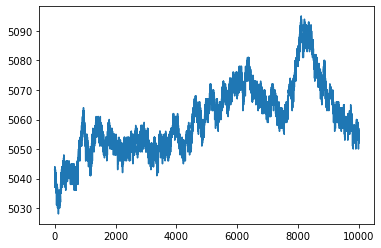

In [462]:
df = pd.read_csv("prices_round_1_day_0.csv", delimiter=";")
starfruit = df[df['product'] == "STARFRUIT"]
plt.plot(range(1,10001), starfruit["ask_price_1"])

# Wavelet transform moving average

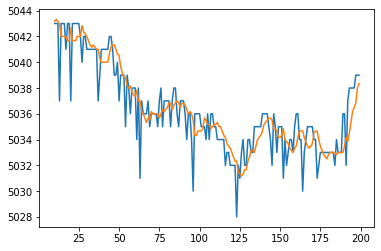

In [463]:
t = 6
window_size = 6
mses = []
full_signal = [np.array([0]) for _ in range(6)]
all_signals = []

for m in range(6, 10000):
    filtered = np.array(starfruit[m-t:m]["ask_price_1"])
    transform = WaveletTransform(waveletName="db4")
    coefficients = transform.dwt(filtered, level=6)
    reconstructed_signal = np.array(transform.idwt(coefficients, level=6))
    
    moving_avg_signal = np.convolve(reconstructed_signal, np.ones(window_size) / window_size, mode='valid')
    full_signal.append(moving_avg_signal)
    
full_signal_avg = np.stack(full_signal).flatten()
plt.plot(range(10,200), starfruit[10:200]["ask_price_1"])
plt.plot(range(10,200), full_signal_avg[10:200])

# Greedy wavelet transform (most recent)

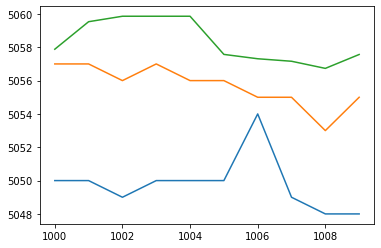

In [490]:
t = 6
full_signal_greedy = [0 for _ in range(t)]

min_t = 1000
max_t = 1010

for m in range(t,10000):
    filtered = np.array(starfruit[m-t:m]["ask_price_1"])
    transform = WaveletTransform(waveletName="db4")
    coefficients = transform.dwt(filtered, level=6)
    reconstructed_signal = np.array(transform.idwt(coefficients, level=6))
    full_signal_greedy.append(np.max(reconstructed_signal))

plt.plot(range(min_t,max_t), starfruit[min_t:max_t]["bid_price_1"])
plt.plot(range(min_t,max_t), starfruit[min_t:max_t]["ask_price_1"])
plt.plot(range(min_t,max_t), full_signal_greedy[min_t:max_t])

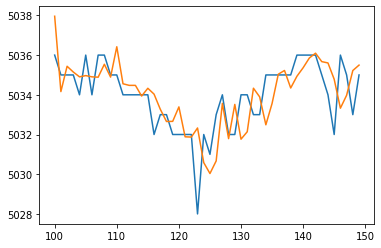

In [453]:
avg = 0.8*np.array(full_signal_greedy) + 0.2*np.array(full_signal_avg)
plt.plot(range(100,150), starfruit[100:150]["ask_price_1"])
plt.plot(range(100,150), avg[100:150])

-6.466432972173852


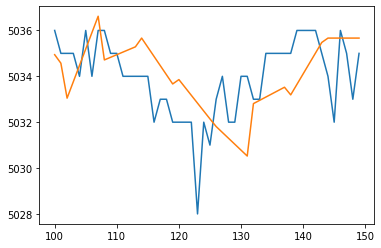

In [454]:
t = 6
mses = []
full_signal = [np.zeros(6,)]
for m in range(t, 10000, t):
    n=6
    filtered = np.array(starfruit[m-t:m]["ask_price_1"])
    timestep = np.arange(6)
    A = np.vstack((timestep,np.ones(len(timestep)))).T
    b, c = np.linalg.lstsq(A, filtered, rcond=None)[0]
    pred = timestep*b+c
    futures = starfruit[m+1:m+n+1]["ask_price_1"]
    
    if (len(pred) == len(futures)):
        mse = np.mean((pred - futures)**2)
        mses.append(mse)
    full_signal.append(pred)
    
full_signal = np.stack(full_signal).flatten()
print(r2_score(full_signal[10:20], starfruit[10:20]["ask_price_1"]))
plt.plot(range(100,150), starfruit[100:150]["ask_price_1"])
plt.plot(range(100,150), full_signal[100:150])